# Results for GDF+PCA+LSTM

Here we present results for the best LSTMs choosen based on best MCC (matthews) score on validation set. 
The features for LSTMs are GDFs reduced by PCA (number of components is chosen based on sum of explained variance ratio > 0.99).

Because LSTMs are not deterministic, the scores may vary, so we calculated scores 30 times for each model. Next we took mean obtained scores, so we can compare with scores obtained for Logistic Regression on Queue Imbalance feature (QUE+LOG).

In [1]:
%load_ext autoreload

%autoreload 2
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score, roc_curve

from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import LSTM


from keras.models import Sequential, model_from_json
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence


import warnings
import numpy as np
from collections import OrderedDict

import os

from lob_data_utils import lob, db_result, gdf_pca, model
from lob_data_utils.svm_calculation import lob_svm


sns.set_style('whitegrid')
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
data_dir = 'res_lstm_best/'
if_should_savefig = False #Change plot names

## Data 

Columns with suffix `lstm` are scores obtained using GDF+PCA+LSTM.

Columns with suffix `log` are scores obtained using QUE+LOG.

Columns with *prefix* `diff` are differences of scores between LSTMs - LOGs.

`r`, `s` - parameters for GDF (s - sigma, r - scale).

In [3]:
df_res = pd.DataFrame()
for f in os.listdir(data_dir):
    l = pd.read_csv(os.path.join(data_dir, f))
    df_res = df_res.append(l)
    print(f, len(l))
df_log = pd.read_csv('res_log_que.csv')    

columns = ['matthews', 'test_matthews', 'stock', 'unit']
df_best = df_res.sort_values(by='matthews', ascending=False).groupby(['stock']).mean()
df_best = pd.merge(df_best, df_log, on='stock', suffixes=['_lstm', '_log'])
df_best.index = df_best['stock']

res_lstm_best_10470_len24000_r0.01_s0.1.csv 30
res_lstm_best_9058_len24000_r0.1_s0.1.csv 30
res_lstm_best_2748_len24000_r0.1_s0.1.csv 30
res_lstm_best_4851_len24000_r0.1_s0.1.csv_partial 30
res_lstm_best_12255_len24000_r0.01_s0.1.csv 30
res_lstm_best_12255_len24000_r0.01_s0.1.csv_partial 30
res_lstm_best_3459_len24000_r0.01_s0.1.csv 30
res_lstm_best_9062_len24000_r0.01_s0.1.csv_partial 30
res_lstm_best_9062_len24000_r0.01_s0.1.csv 30
res_lstm_best_4851_len24000_r0.1_s0.1.csv 30
res_lstm_best_9061_len24000_r0.01_s0.1.csv_partial 30
res_lstm_best_9761_len24000_r0.01_s0.1.csv_partial 30
res_lstm_best_10470_len24000_r0.01_s0.1.csv_partial 30
res_lstm_best_9761_len24000_r0.01_s0.1.csv 30
res_lstm_best_9058_len24000_r0.1_s0.1.csv_partial 30
res_lstm_best_9061_len24000_r0.01_s0.1.csv 30
res_lstm_best_4320_len24000_r0.1_s0.1.csv_partial 30
res_lstm_best_2748_len24000_r0.1_s0.1.csv_partial 30
res_lstm_best_11583_len24000_r0.01_s0.5.csv 30
res_lstm_best_4549_len24000_r0.1_s0.1.csv_partial 30
res

Text(0.5,1,'ROC scores for GDF+PCA+LSTM')

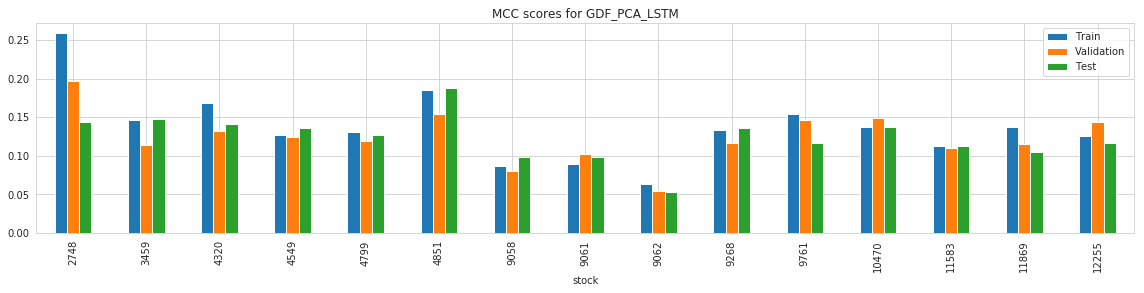

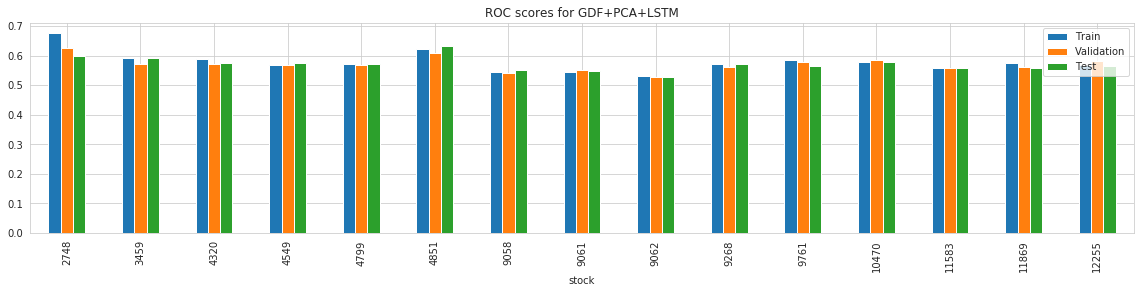

In [4]:
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test'])
plt.tight_layout()
plt.title('MCC scores for GDF_PCA_LSTM')

df_best[['train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].plot(kind='bar', figsize=(16, 4))
plt.legend(['Train', 'Validation', 'Test'])
plt.tight_layout()
plt.title('ROC scores for GDF+PCA+LSTM')

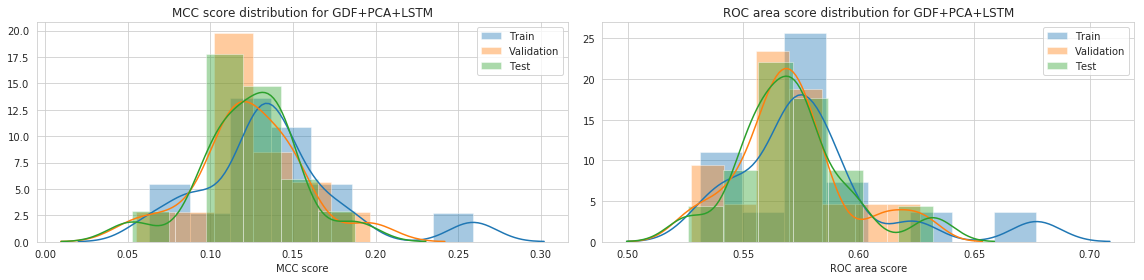

In [5]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))
sns.distplot(df_best['train_matthews_lstm'], label='Train', ax=ax1)
sns.distplot(df_best['matthews_lstm'], label='Validation', ax=ax1)
sns.distplot(df_best['test_matthews_lstm'], label='Test', ax=ax1)
ax1.legend(['Train', 'Validation', 'Test'])
ax1.set_title('MCC score distribution for GDF+PCA+LSTM')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['train_roc_auc_lstm'], label='Train', ax=ax2)
sns.distplot(df_best['roc_auc_lstm'], label='Validation', ax=ax2)
sns.distplot(df_best['test_roc_auc_lstm'], label='Test', ax=ax2)
ax2.legend(['Train', 'Validation', 'Test'])
ax2.set_title('ROC area score distribution for GDF+PCA+LSTM')
ax2.set_xlabel('ROC area score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_score_dist.png')

In [6]:
df_best[['train_matthews_lstm', 'matthews_lstm', 'test_matthews_lstm', 
        'train_roc_auc_lstm', 'roc_auc_lstm', 'test_roc_auc_lstm']].describe()

,train_matthews_lstm,matthews_lstm,test_matthews_lstm,train_roc_auc_lstm,roc_auc_lstm,test_roc_auc_lstm
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.137063,0.123713,0.123715,0.579033,0.570732,0.571053
std,0.045991,0.033144,0.030321,0.035077,0.024774,0.024476
min,0.062973,0.054905,0.052380,0.531574,0.527421,0.526305
25%,0.118931,0.111384,0.108343,0.564017,0.559577,0.557675
50%,0.133941,0.119149,0.126886,0.572260,0.568276,0.570269
75%,0.150347,0.144638,0.139597,0.587234,0.579255,0.577187
max,0.259069,0.196399,0.187655,0.676988,0.626692,0.632089


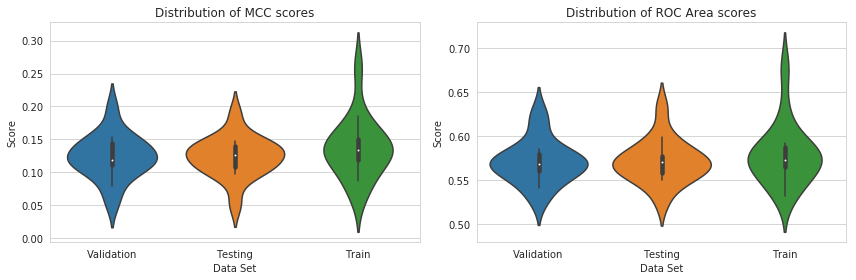

In [7]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'matthews_lstm', 'roc_auc_lstm', 
           'test_matthews_lstm', 'test_roc_auc_lstm', 'train_matthews_lstm', 'train_roc_auc_lstm']

df = df_best[columns].copy()
df.rename(columns={
    'matthews_lstm': 'Validation', 'test_matthews_lstm': 'Testing', 'train_matthews_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'roc_auc_lstm', 'test_roc_auc_lstm', 'train_roc_auc_lstm'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(columns={'roc_auc_lstm': 'Validation', 'test_roc_auc_lstm': 'Testing', 'train_roc_auc_lstm': 'Train'}, inplace=True)
df = df.melt(['stock', 'matthews_lstm', 'test_matthews_lstm', 'train_matthews_lstm'])

ax2.set_title('Distribution of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('violin_distribution_scores_gdf_pca_lstm.png')

Text(0.5,1,'Number of timesteps for LSTM')

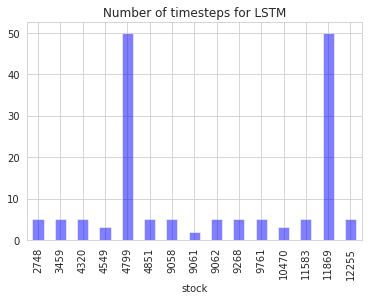

In [8]:
df_best['n_steps'].plot(kind='bar', color=['b'], alpha=0.5)
plt.title('Number of timesteps for LSTM')

## Comparision with QUE+LOG

In [9]:
df_best['diff_test_matthews'] = df_best['test_matthews_lstm'] - df_best['test_matthews_log']
df_best['diff_train_matthews'] = df_best['train_matthews_lstm'] - df_best['train_matthews_log']
df_best['diff_matthews'] = df_best['matthews_lstm'] - df_best['matthews_log']
df_best['diff_test_roc_auc'] = df_best['test_roc_auc_lstm'] - df_best['test_roc_auc_log']
df_best['diff_train_roc_auc'] = df_best['train_roc_auc_lstm'] - df_best['train_roc_auc_log']
df_best['diff_roc_auc'] = df_best['roc_auc_lstm'] - df_best['roc_auc_log']

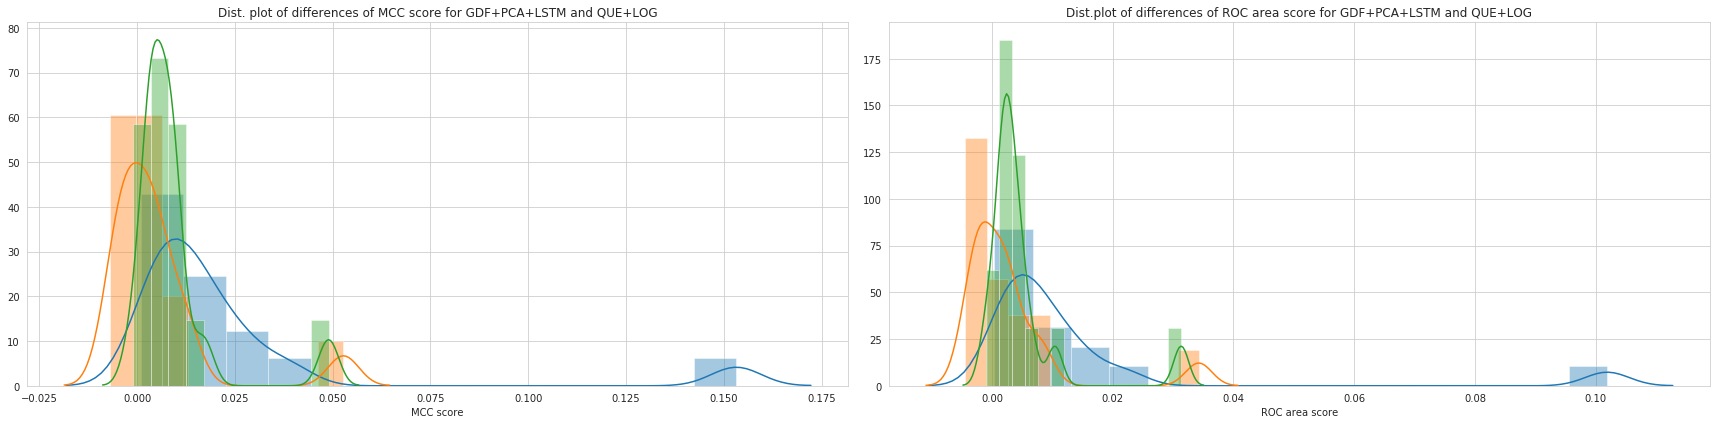

In [10]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 6))
sns.distplot(df_best['diff_train_matthews'], label='Train', ax=ax1)
sns.distplot(df_best['diff_matthews'], label='Validation', ax=ax1)
sns.distplot(df_best['diff_test_matthews'], label='Test', ax=ax1)
ax1.set_title('Dist. plot of differences of MCC score for GDF+PCA+LSTM and QUE+LOG')
ax1.set_xlabel('MCC score')

sns.distplot(df_best['diff_train_roc_auc'], label='Train', ax=ax2)
sns.distplot(df_best['diff_roc_auc'], label='Validation', ax=ax2)
sns.distplot(df_best['diff_test_roc_auc'], label='Test', ax=ax2)
ax2.set_title('Dist.plot of differences of ROC area score for GDF+PCA+LSTM and QUE+LOG')
ax2.set_xlabel('ROC area score')
plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_score_diff.png')

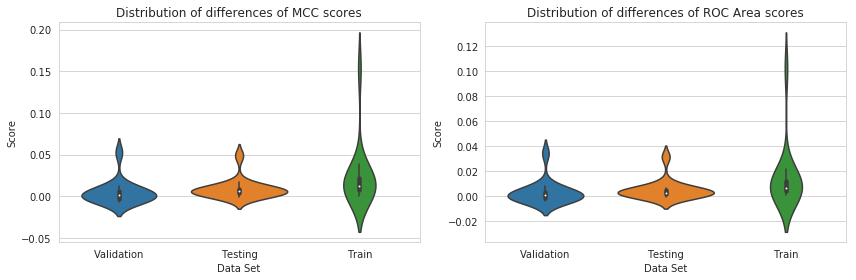

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

columns = ['stock', 'diff_matthews', 'diff_roc_auc', 
           'diff_test_matthews', 'diff_test_roc_auc', 'diff_train_matthews', 'diff_train_roc_auc']

df = df_best[columns].copy()
df.rename(columns={
    'diff_matthews': 'Validation', 'diff_test_matthews': 'Testing', 'diff_train_matthews': 'Train'}, inplace=True)
df = df.melt(['stock', 'diff_roc_auc', 'diff_test_roc_auc', 'diff_train_roc_auc'])
sns.violinplot(x="variable", y="value", data=df, ax=ax1)
ax1.set_title('Distribution of differences of MCC scores')

ax1.set_xlabel('Data Set')
ax1.set_ylabel('Score')

df = df_best[columns].copy()
df.rename(
    columns={'diff_roc_auc': 'Validation', 'diff_test_roc_auc': 'Testing', 'diff_train_roc_auc': 'Train'}, 
    inplace=True)
df = df.melt(['stock', 'diff_matthews', 'diff_test_matthews', 'diff_train_matthews'])

ax2.set_title('Distribution of differences of ROC Area scores')

sns.violinplot(x="variable", y="value", data=df, ax=ax2)
ax2.set_xlabel('Data Set')
ax2.set_ylabel('Score')

plt.tight_layout()
if if_should_savefig:
    plt.savefig('gdf_pca_lstm_and_que_log_violin_score_diff.png')

The table below shows the values for the differences, which distributions are on a plot above.

In [12]:
df_best[['diff_train_matthews', 'diff_matthews', 'diff_test_matthews', 
        'diff_train_roc_auc', 'diff_roc_auc', 'diff_test_roc_auc']].describe()

,diff_train_matthews,diff_matthews,diff_test_matthews,diff_train_roc_auc,diff_roc_auc,diff_test_roc_auc
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.023682,0.005118,0.009228,0.014033,0.003022,0.005045
std,0.037300,0.014420,0.011809,0.024991,0.009378,0.007771
min,0.000940,-0.006786,-0.001091,0.000399,-0.004403,-0.001058
25%,0.007987,-0.002691,0.003598,0.003933,-0.001800,0.001891
50%,0.012352,0.001846,0.006988,0.006432,0.001060,0.002644
75%,0.021904,0.005950,0.009217,0.011863,0.002956,0.004624
max,0.153214,0.052772,0.048976,0.101890,0.034248,0.031342


In [13]:
print('stocks having worse roc area score for LSTM vs LOG on test set')
print(df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']]['stock'].values)
df_best[df_best['test_roc_auc_lstm'] < df_best['test_roc_auc_log']][[
    'roc_auc_lstm', 'roc_auc_log', 'test_roc_auc_lstm', 'test_roc_auc_log', 'r', 's']]

stocks having worse roc area score for LSTM vs LOG on test set
[11869]


,roc_auc_lstm,roc_auc_log,test_roc_auc_lstm,test_roc_auc_log,r,s
stock,,,,,,
11869,0.563074,0.566097,0.556664,0.557722,0.1,0.1


In [14]:
print('stocks having worse MCC score for LSTM vs LOG on test set')
df_best[df_best['test_matthews_lstm'] < df_best['test_matthews_log']][[
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

stocks having worse MCC score for LSTM vs LOG on test set


,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,
11869,0.115391,0.120455,0.104195,0.105285,0.1,0.1


In [15]:
df_best[['train_matthews_lstm', 'train_matthews_log',
    'matthews_lstm', 'matthews_log', 'test_matthews_lstm', 'test_matthews_log', 'r', 's']]

,train_matthews_lstm,train_matthews_log,matthews_lstm,matthews_log,test_matthews_lstm,test_matthews_log,r,s
stock,,,,,,,,
2748,0.259069,0.105855,0.196399,0.143627,0.143668,0.134270,0.10,0.1
3459,0.146770,0.129963,0.113410,0.120196,0.147781,0.130774,0.01,0.1
4320,0.167660,0.142469,0.132177,0.135224,0.141502,0.133149,0.10,0.1
4549,0.127423,0.119528,0.124662,0.122816,0.136484,0.133548,0.10,0.1
4799,0.130216,0.111598,0.119149,0.123985,0.126886,0.124435,0.01,0.1
4851,0.184930,0.146122,0.153419,0.141509,0.187655,0.138680,0.10,0.1
9058,0.086952,0.078873,0.079610,0.074776,0.098889,0.091455,0.10,0.1
9061,0.089868,0.084134,0.102091,0.095738,0.097954,0.090966,0.01,0.1
9062,0.062973,0.062033,0.054905,0.057241,0.052380,0.047951,0.01,0.1


## Conclusions

We are using very simple LSTM model. I tried also more complicated ones, but they were overfitting.

In [16]:
df_best[['train_roc_auc_lstm', 'train_roc_auc_log',
    'roc_auc_lstm', 'roc_auc_log', 'test_roc_auc_lstm', 'test_roc_auc_log', 'r', 's']]

,train_roc_auc_lstm,train_roc_auc_log,roc_auc_lstm,roc_auc_log,test_roc_auc_lstm,test_roc_auc_log,r,s
stock,,,,,,,,
2748,0.676988,0.575097,0.626692,0.592444,0.598785,0.596587,0.10,0.1
3459,0.592038,0.581691,0.571826,0.576229,0.591958,0.581522,0.01,0.1
4320,0.590294,0.576916,0.571965,0.573640,0.576517,0.572081,0.10,0.1
4549,0.569539,0.565663,0.568276,0.567216,0.575304,0.574059,0.10,0.1
4799,0.571019,0.562566,0.566910,0.569671,0.570269,0.570149,0.01,0.1
4851,0.623696,0.601755,0.610515,0.602119,0.632089,0.600747,0.10,0.1
9058,0.544232,0.540243,0.540568,0.538148,0.550245,0.546640,0.10,0.1
9061,0.545246,0.542446,0.550957,0.547950,0.549463,0.545994,0.01,0.1
9062,0.531574,0.531175,0.527421,0.528676,0.526305,0.524117,0.01,0.1


In [17]:
df_best[['train_roc_auc_lstm', 'train_roc_auc_log',
    'roc_auc_lstm', 'roc_auc_log', 'test_roc_auc_lstm', 'test_roc_auc_log']].describe()

,train_roc_auc_lstm,train_roc_auc_log,roc_auc_lstm,roc_auc_log,test_roc_auc_lstm,test_roc_auc_log
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.579033,0.564999,0.570732,0.567710,0.571053,0.566008
std,0.035077,0.017799,0.024774,0.019417,0.024476,0.019496
min,0.531574,0.531175,0.527421,0.528676,0.526305,0.524117
25%,0.564017,0.557315,0.559577,0.558588,0.557675,0.557095
50%,0.572260,0.567023,0.568276,0.569671,0.570269,0.570149
75%,0.587234,0.574729,0.579255,0.578162,0.577187,0.573070
max,0.676988,0.601755,0.626692,0.602119,0.632089,0.600747


In [18]:
df_best[['train_f1_lstm', 'train_f1_log',
    'f1_lstm', 'f1_log', 'test_f1_lstm', 'test_f1_log']].describe()

,train_f1_lstm,train_f1_log,f1_lstm,f1_log,test_f1_lstm,test_f1_log
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.433444,0.423818,0.421759,0.418661,0.424390,0.421022
std,0.048548,0.066287,0.058374,0.068342,0.059999,0.067065
min,0.335044,0.280039,0.297313,0.275834,0.296902,0.287706
25%,0.410790,0.410888,0.411494,0.408632,0.402584,0.411209
50%,0.429808,0.432429,0.426806,0.428456,0.427829,0.430924
75%,0.475049,0.467611,0.465806,0.464494,0.467463,0.459444
max,0.499318,0.509771,0.505145,0.507121,0.501405,0.511161


In [19]:
df_best[['train_recall_lstm', 'train_recall_log',
    'recall_lstm', 'recall_log', 'test_recall_lstm', 'test_recall_log']].describe()

,train_recall_lstm,train_recall_log,recall_lstm,recall_log,test_recall_lstm,test_recall_log
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.565542,0.572689,0.567207,0.567227,0.556172,0.568289
std,0.048308,0.021083,0.052561,0.044384,0.045429,0.040478
min,0.491042,0.532499,0.484531,0.496546,0.495762,0.519594
25%,0.527976,0.562464,0.521998,0.539487,0.518750,0.549723
50%,0.565424,0.571783,0.569188,0.556429,0.549853,0.561000
75%,0.596888,0.585878,0.601209,0.599597,0.593498,0.570938
max,0.660660,0.611383,0.660927,0.641646,0.633763,0.687964


In [20]:
df_best[['train_precision_lstm', 'train_precision_log',
    'precision_lstm', 'precision_log', 'test_precision_lstm', 'test_precision_log']].describe()

,train_precision_lstm,train_precision_log,precision_lstm,precision_log,test_precision_lstm,test_precision_log
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.360907,0.346226,0.350105,0.347525,0.352260,0.345817
std,0.075234,0.086779,0.084723,0.085588,0.081274,0.087073
min,0.239165,0.184566,0.194163,0.189234,0.207697,0.184830
25%,0.322333,0.317436,0.318355,0.315959,0.326522,0.325722
50%,0.357362,0.348725,0.347388,0.348114,0.350933,0.345878
75%,0.404998,0.394342,0.391725,0.390768,0.394265,0.391742
max,0.483043,0.480502,0.489906,0.485178,0.476117,0.469455


In [21]:
df_best[['train_kappa_lstm', 'train_kappa_log',
    'kappa_lstm', 'kappa_log', 'test_kappa_lstm', 'test_kappa_log']].describe()

,train_kappa_lstm,train_kappa_log,kappa_lstm,kappa_log,test_kappa_lstm,test_kappa_log
count,15.000000,15.000000,15.000000,15.000000,15.000000,15.000000
mean,0.125468,0.102074,0.111471,0.106177,0.113123,0.102967
std,0.036438,0.018955,0.028212,0.021380,0.023039,0.019507
min,0.062939,0.061738,0.054853,0.057121,0.052307,0.047593
25%,0.110133,0.089891,0.102229,0.097422,0.101406,0.094988
50%,0.122629,0.108231,0.111628,0.107205,0.121038,0.103878
75%,0.135737,0.113659,0.125991,0.120300,0.125612,0.115849
max,0.218599,0.133286,0.174729,0.140536,0.154316,0.125494
